In [1]:
from auxillary import *
from indicators import createFeatures
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, lognorm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


In [2]:
symbol = "MSFT"
ticker = yf.Ticker(symbol).history("max")
df = adjustPrices(ticker)
cont_vars, cat_vars = createFeatures(df)
cont_vars = cont_vars.drop(["Stock Splits", "Dividends"], axis=1)

In [3]:
n = 10
target_price = calculateFuturePrice(ticker, n)
target_price_change = calculateFuturePriceChange(ticker, n)
target_price_class = calculateFuturePriceClass(ticker, n)


In [5]:
target_df = pd.DataFrame([target_price, target_price_change, target_price_class]).T
target_df.columns = ["Future_Price", "Future_Price_Change", "Future_Price_Class"]
target_df

,Future_Price,Future_Price_Change,Future_Price_Class
Date,,,
1986-03-13 00:00:00-05:00,0.060115,-0.008928,1.0
1986-03-14 00:00:00-05:00,0.059574,-0.051721,1.0
1986-03-17 00:00:00-05:00,0.059032,-0.076276,1.0
1986-03-18 00:00:00-05:00,0.059574,-0.043475,1.0
1986-03-19 00:00:00-05:00,0.060115,-0.017698,1.0
...,...,...,...
2023-03-31 00:00:00-04:00,NaN,NaN,NaN
2023-04-03 00:00:00-04:00,NaN,NaN,NaN
2023-04-04 00:00:00-04:00,NaN,NaN,NaN


In [46]:
scaler = StandardScaler()
scaled_cont_vars = scaler.fit_transform(cont_vars)
scaled_cont_vars = pd.DataFrame(scaled_cont_vars, columns= cont_vars.columns, index = cont_vars.index)


In [48]:
for i in scaled_cont_vars.columns:
    col_name = i + "_ROC"
    scaled_cont_vars[col_name] = rocApproximation(scaled_cont_vars[i])

In [50]:
# Log normal percentiles
log_norm_cols = ["ADX", "ADX_ROC", "Aroon_Up_ROC", "Aroon_Down_ROC"]
for i in log_norm_cols:
    p = lognorm(loc = scaled_cont_vars[i].mean(), s = scaled_cont_vars[i].std()).cdf(scaled_cont_vars[i])
    col_name = i + "_Percentile"
    scaled_cont_vars[col_name] = p

In [52]:
# Normal percentiles
norm_cols = ["CCI", "Disparity", "KST", "MACD", "OBV", "RSI", "RVI", "Stochastic_Oscillator_ROC", "RVI_ROC", "KST_ROC", "MACD_ROC", "OBV_ROC", "RSI_ROC"]

for i in norm_cols:
    p = norm(loc = scaled_cont_vars[i].mean(), scale = scaled_cont_vars[i].std()).cdf(scaled_cont_vars[i])
    col_name = i + "_Percentile"
    scaled_cont_vars[col_name] = p

In [55]:
regular_df = pd.concat([scaled_cont_vars, cat_vars], axis = 1)

,Open,High,Low,Close,Volume,ADX,Aroon_Up,Aroon_Down,CCI,Disparity,...,Aroon_Crossover,Aroon_Indicator,CCI_Indicator,Disparity_Indicator,KST_Crossover,MACD_Crossover,RSI_Indicator,RVI_Crossover,RVI_Divergence,Stochastic_Oscillator_Indicator
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-13 00:00:00-05:00,-0.695659,-0.695695,-0.695525,-0.695435,25.461921,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1986-03-14 00:00:00-05:00,-0.695457,-0.695675,-0.695320,-0.695354,6.542103,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,-1,0,0,0
1986-03-17 00:00:00-05:00,-0.695376,-0.695655,-0.695238,-0.695314,1.966889,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,-1,0,0,0
1986-03-18 00:00:00-05:00,-0.695335,-0.695655,-0.695279,-0.695375,0.256832,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,-1,0,0,0
1986-03-19 00:00:00-05:00,-0.695396,-0.695715,-0.695320,-0.695415,-0.262737,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 00:00:00-04:00,3.138392,3.172824,3.170758,3.198990,-0.658952,0.224301,1.223144,-0.705731,5.862797,0.974946,...,0,1,0,0,0,0,-1,0,-1,-1
2023-04-03 00:00:00-04:00,3.176113,3.159443,3.183744,3.184528,-0.864379,0.370298,1.111326,-0.819198,4.734734,0.703339,...,0,1,0,0,0,0,-1,0,0,0
2023-04-04 00:00:00-04:00,3.185713,3.188615,3.207255,3.183852,-0.839776,0.507283,1.223144,-0.932665,4.530279,0.556407,...,0,1,0,0,0,0,-1,0,1,0


In [68]:

pca = PCA(n_components=len(regular_df.columns)//2)

#fit PCA model to data
pc_df = pd.DataFrame(pca.fit_transform(regular_df.dropna()), index = regular_df.dropna().index)

variance_explained = pca.explained_variance_ratio_


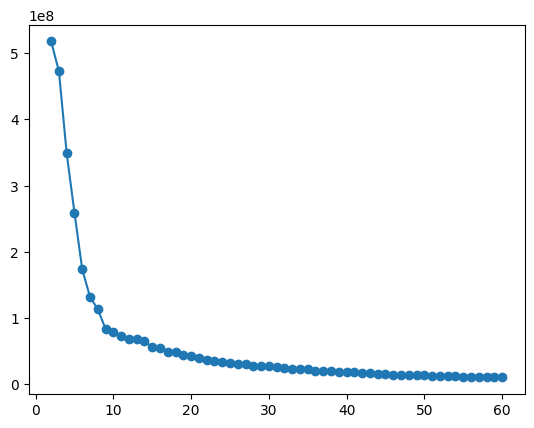

In [63]:
k = []
wcv = []
for i in range(2, len(regular_df.columns) + 1):
    kmeans = KMeans(n_clusters=i, n_init="auto").fit(regular_df.dropna())
    wcv.append(kmeans.inertia_)
    k.append(i)

plt.plot(k, wcv, "o-")

In [70]:
clusterdf = pd.DataFrame(KMeans(n_clusters=6, n_init="auto").fit_transform(regular_df.dropna()), index = regular_df.dropna().index)